# Ocular Disease Intelligent Recognition

Project Group 3:
- Melanie Ullrich
- Simon Pauka
- Youssef Aloulou

## 1. Introduction

Researchers have determined that fundus diseases are among the main causes of blindness worldwide, making ophthalmic conditions a significant public health concern. Manual fundus screening is both time-consuming and requires highly skilled professionals for accurate detection. Early identification of these diseases is crucial for preventing visual diminution. In this context, automated disease recognition using deep learning offers a promising solution to address these challenges effectively. [[1]](https://arxiv.org/abs/2102.07978v1)

The challenge is that there are always two eyes in a person, so the images are linked, and in the medical field it is important to consider both in order to achieve realistic and clinically relevant results.

**Objectives**

This project aims to develop a classification model for fundus diseases with creating a robust classifier capable of accurately categorizing the given images into multiple disease types. A further important aspect was to consider the two eyes of a patient as one entity. To achieve this, a good pre-processing pipeline and efficient data loading needed to be found.

**Plan of approach**

In order to achieve these objectives, the subsequent steps are followed within the project. To gain insights into the given dataset and its characteristics, it is first necessary to explore and understand the data.  To identify patterns, distributions and potential outliers that could impact the model's performance visualizations of a sample set and a histogram of the distribution is implemented. Additionally this includes the efficient loading of data, which also determines the preferred structure for further processing. The next steps involves preparing to implement the training process. This includes splitting and normalize the dataset and define the model architecture. The approach is to use the pre-trained model VGG16 as base model for feature extraction and a simple classifier as top model. For validation of the models performance four metrics are used for comparision with the benchmark. This includes Kappa, F1- score (F1), AUC and their mean value, denoted as Final-score.

In [ ]:
import os
import re
from tqdm import tqdm
import pandas as pd
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from PIL import Image
from torchvision import transforms
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2


from google.colab import drive
drive.mount('/content/drive')

path_root = "/content/drive/MyDrive/ADMEAV_Project/"

Mounted at /content/drive


## 2. Data Loading

The dataset includes a training and a test dataset of images in jpg-files. A corresponding excel-file contains metadata and annotations for the left and right eye-image. The labels contain a total of 8 classes. As the annotation was created for both pairs of eyes together, each pair can be assigned to several classes. The annotation is binary for every class, where a 1 means an assignment and a 0 means no assignment. The training dataset contains in total 3.500 images. Since the test dataset has no annotations within the excel-file, a split into train, validation and test data is necessary. After splitting the train-data consists of 2.275 train- , 525 validation- and 700 testdata.

The chosen data structure is a tensor that contains multiple tensor of the embedded images of both eyes and a tensor of the annotation.

For a faster training process the introduction of two different data loading functions were implemented. The class ODIRDataset( ) includes image cropping and a lower dataset creation time, the ODIRDataset_2( ) class provides a faster training time by loading the data directly into RAM.

In [ ]:
# get unique samples in the dataset
def get_unique_sample_numbers(imgs):
  unique_numbers = []
  for img_name in imgs:
    # Extract the number using a regular expression
    match = re.search(r"(\d+)_", img_name)
    if match:
      number = int(match.group(1))
      if number not in unique_numbers:
        unique_numbers.append(number) #append to list if unique
  return unique_numbers

In [15]:
new_mean, new_std = (0.0509, 0.2404, 1.6657), (0.3090, 0.2115, 0.1740)
mean, std = (0.4343, 0.2787, 0.1525), (0.2878, 0.2080, 0.1454) # updated for the newly cropped images 13.01 16:05

# Data Loading by putting all of the images into the RAM at once - needs about 8G of RAM
class ODIRDataset_2(Dataset):
    """Dataset Loading - Loads the images and transforms those to a normalized tensor. Loads the excel-file and creates a tensor of the annotations.

    Args:
        Dataset: the path to the root folder of the dataset
    """

    def __init__(self, root):
        self.root = root # Root path where the dataset is located
        # Define paths for image and annotation directories
        self.imageFolderName = "TrainingImages_cropped"
        self.imgs = list(sorted(os.listdir(os.path.join(root, self.imageFolderName))))

        # Get the IDs of the images in the Training Images folder
        self.img_IDs = get_unique_sample_numbers(self.imgs)
        self.img_IDs.sort()

        # Get the metainfo and annotations
        self.dataframe = pd.read_excel(os.path.join(root, "data.xlsx"), )

        # Make sure that we only use images for that we have the annotations (maybe not necessary)
        self.img_IDs = [img_id for img_id in self.img_IDs if img_id in self.dataframe["ID"].values]

        # Reisze the images to 224x224 pixel, normalize it with mean and standard deviation and transform to a tensor
        self.transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])

        #load images and apply transform
        self.images = {
            img_id: {
                "left": self.transforms(Image.open(os.path.join(self.root, self.imageFolderName, f"{img_id}_left.jpg")).convert("RGB")),
                "right": self.transforms(Image.open(os.path.join(self.root, self.imageFolderName, f"{img_id}_right.jpg")).convert("RGB")),
            }
            for img_id in tqdm(self.img_IDs)
        }

    def __getitem__(self, idx):
        imgID = self.img_IDs[idx]
        img_left = self.images[imgID]["left"]
        img_right = self.images[imgID]["right"]

        # Metainfo is everything else given in the file, such as age, sex and keywords
        # For now lets just return them in a dict as we might use them later to support classification

        metainfo_list = self.dataframe[self.dataframe["ID"] == imgID]

        metainfo = {}
        '''
        metainfo["age"] = metainfo_list["Patient Age"].values[0]
        metainfo["sex"] = metainfo_list["Patient Sex"].values[0]
        metainfo["left_key"] = metainfo_list["Left-Diagnostic Keywords"].values[0]
        metainfo["right_key"] = metainfo_list["Right-Diagnostic Keywords"].values[0]
        '''

        # Annotation is in a "multiple-hot" vector with 8 entries corresponding to the 8 classes
        # a vector might look like this for a image pair: [0, 1, 0, 0, 0, 1, 0, 0]
        annotation = [metainfo_list["N"].values[0], metainfo_list["D"].values[0], metainfo_list["G"].values[0], metainfo_list["C"].values[0],
                      metainfo_list["A"].values[0], metainfo_list["H"].values[0], metainfo_list["M"].values[0], metainfo_list["O"].values[0]]
        annotation = torch.tensor(annotation, dtype=torch.float32)

        return img_left, img_right, metainfo, annotation # return both imgs, metainfo and annotation vector

    def __len__(self):
        # return the length of the dataset
        return len(self.img_IDs)


# create dataset
dataset = ODIRDataset_2(path_root)


100%|██████████| 3500/3500 [10:25<00:00,  5.60it/s]


In [ ]:
# Data Loading by loading the images once the method is called
class ODIRDataset(Dataset):
    """Dataset Loading - Loads the images and transforms those to a normalized tensor. Loads the excel-file and creates a tensor of the annotations.

    Args:
        Dataset: the path to the root folder of the dataset
    """

    def __init__(self, root):
        self.root = root # Root path where the dataset is located
        # Define paths for image and annotation directories
        self.imageFolderName = "TrainingImages_cropped"
        self.imgs = list(sorted(os.listdir(os.path.join(root, self.imageFolderName))))

        # Get the IDs of the images in the Training Images folder
        self.img_IDs = get_unique_sample_numbers(self.imgs)
        self.img_IDs.sort()

        # Get the metainfo and annotations
        self.dataframe = pd.read_excel(os.path.join(root, "data.xlsx"), )

        # Make sure that we only use images for that we have the annotations (maybe not necessary)
        self.img_IDs = [img_id for img_id in self.img_IDs if img_id in self.dataframe["ID"].values]

        # Transform the images to 224x224 pixel and to a tensor
        self.transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])

    def __getitem__(self, idx):
        imgID = self.img_IDs[idx]
        img_path_left = os.path.join(self.root, self.imageFolderName , str(imgID) + "_left.jpg")
        img_path_right = os.path.join(self.root, self.imageFolderName , str(imgID) + "_right.jpg")

        # Metainfo is everything else given in the file, such as age, sex and keywords
        # For now lets just return them in a dict as we might use them later to support classification

        metainfo_list = self.dataframe[self.dataframe["ID"] == imgID]

        metainfo = {}
        '''
        metainfo["age"] = metainfo_list["Patient Age"].values[0]
        metainfo["sex"] = metainfo_list["Patient Sex"].values[0]
        metainfo["left_key"] = metainfo_list["Left-Diagnostic Keywords"].values[0]
        metainfo["right_key"] = metainfo_list["Right-Diagnostic Keywords"].values[0]
        '''

        # Annotation is in a "multiple-hot" vector with 8 entries corresponding to the 8 classes
        # a vector might look like this for a image pair: [0, 1, 0, 0, 0, 1, 0, 0]
        annotation = [metainfo_list["N"].values[0], metainfo_list["D"].values[0], metainfo_list["G"].values[0], metainfo_list["C"].values[0],
                      metainfo_list["A"].values[0], metainfo_list["H"].values[0], metainfo_list["M"].values[0], metainfo_list["O"].values[0]]
        annotation = torch.tensor(annotation, dtype=torch.float32)

        # Load image and apply transform
        img_left = Image.open(img_path_left).convert("RGB")
        img_right = Image.open(img_path_right).convert("RGB")

        # Detect circle and crop (for both left and right images)
        # img_left = self.detect_and_crop_circle(img_left)
        # img_right = self.detect_and_crop_circle(img_right)

        img_left = self.transforms(img_left)
        img_right = self.transforms(img_right)

        return img_left, img_right, metainfo, annotation # return both imgs, metainfo and annotation vector

    def detect_and_crop_circle(self, img):
        # Convert image to grayscale
        img_gray = img.convert("L")
        img_np = np.array(img_gray)

        # Find rows and columns where pixel values are not black (0)
        non_black_rows = np.where(np.any(img_np != 0, axis=1))[0]
        non_black_cols = np.where(np.any(img_np != 0, axis=0))[0]

        # Get the bounding box coordinates
        x = non_black_cols[0]  # Leftmost non-black column
        y = non_black_rows[0]  # Topmost non-black row
        w = non_black_cols[-1] - x + 1  # Width
        h = non_black_rows[-1] - y + 1  # Height

        # Crop the image
        cropped_img = img.crop((x, y, x + w, y + h))

        return cropped_img

    def __len__(self):
        # return the length of the dataset
        return len(self.img_IDs)


# create dataset
dataset = ODIRDataset(path_root)

## 3. Data Exploration and Preprocessing

To explore the dataset, a visualization of a few samples from the dataset is implemented. Furthermore the class distribution is visualized.

The preprocessing pipeline includes splitting the dataset into train, validation and test subset and finding the normalization parameters from the training dataset. This is nessecary to obtain the statistics for the training data and apply the same parameters to the validation and test data to ensure consistency. The normalization and resizing was then implemented in the data loading class. Image normalization is important in order to ensure the best possible comparisons between different data acquisition methods and texture instances. Data augmentation was not required due to the large number of images in the dataset.

### 3.1 Data split

In [16]:
# class description
classes = ["(N) Normal", "(D) Diabetes", "(G) Glaucoma", "(C) Cataract", "(A) Age related Macular Degeneration", "(H) Hypertension", "(M) Pathological Myopia", "(O) Other"]

def split_dataset(dataset):
    """Splits the dataset into train, validation and test data.

    Args:
        dataset: The dataset to be split loaded by the class ODIRDataset.

    Returns:
        Three subsets of the dataset - Training, Validation and Test subset
    """
    # Create a list of indices ranging from 0 to the length of the dataset
    indices = list(range(len(dataset)))
    # Set a fixed random seed for reproducibility and shuffle
    random.seed(123)
    random.shuffle(indices)
    # Determine the size of the training set as 65%, validation set as 15% and test set as 20% of the total dataset and create the subsets
    train_size = int(0.65 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = int(0.2 * len(dataset))
    X_train = torch.utils.data.Subset(dataset, indices[:train_size])
    X_val = torch.utils.data.Subset(dataset, indices[train_size:train_size + val_size])
    X_test = torch.utils.data.Subset(dataset, indices[train_size + val_size:])
    return X_train, X_val, X_test

X_train, X_val, X_test = split_dataset(dataset)

#print the length of each subset
print(f'Length of the dataset: {len(dataset)}')
print(f'Length of the Training dataset: {len(X_train)}')
print(f'Length of the Validation dataset: {len(X_val)}')
print(f'Length of the Test dataset: {len(X_test)}')

Length of the dataset: 3500
Length of the Training dataset: 2275
Length of the Validation dataset: 525
Length of the Test dataset: 700


In [17]:
# Create torch dataloaders with the batch size 16
batch_size = 16
train_loader = DataLoader(X_train,batch_size=batch_size, shuffle=True)
val_loader = DataLoader(X_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=False)

### Image cropping

During the visualization of the data samples, it was discovered that the resizing of the images results in distorted images, as the original ones are not all of the same size. Therefore, the images are cropped to the size of the retina, eliminating the black background pixels. This only was executed once to get the cropped images

In [ ]:
# Image cropping copied from : https://github.com/okbabent/-fev22-ocular-disease/blob/main/odir_notebook.ipynb
import cv2
import numpy as np
import PIL
from PIL import Image
from tqdm import tqdm

class ImageUtils:

    @staticmethod
    def remove_black_pixels(source_folder, destination_folder, file_name):
        if not os.path.exists(destination_folder):
            os.mkdir(destination_folder)

        # path image
        file = os.path.join(source_folder, file_name)

        #Lecture image
        image = cv2.imread(file)

        # Mask pour tous les pixels colorés
        mask = image > 0

        # les coo des pixels colorés.
        coordinates = np.argwhere(mask)

        # Chercher la bounding box des pixels qui ne sont pas noirs
        x0, y0, s0 = coordinates.min(axis=0)
        x1, y1, s1 = coordinates.max(axis=0) + 1

        # Cropped boounding box
        cropped = image[x0:x1, y0:y1]

        # l'image cropped
        file_cropped = os.path.join(destination_folder, file_name)
        cv2.imwrite(file_cropped, cropped)

    @staticmethod
    def resize_image(source_folder, destination_folder, image_width, image_height, quality, keep_aspect_ratio, file_name):
        file = os.path.join(source_folder, file_name)
        img = Image.open(file)
        if keep_aspect_ratio:
            # it will produce the same with-to-height ratio as the original image
            width_percentage = (image_width / float(img.size[0]))
            height_size = int((float(img.size[1]) * float(width_percentage)))
            img = img.resize((image_width, height_size), PIL.Image.ANTIALIAS)
        else:
            img = img.resize((image_width, image_height), PIL.Image.ANTIALIAS)

        img.save(os.path.join(destination_folder, file_name), optimize=True, quality=quality)


    @staticmethod
    def crop_all_images(source_folder, destination_folder):
        files = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]
        pbar = tqdm(files)
        for file in pbar:
            pbar.set_description('Cropping image: ' + file)
            ImageUtils.remove_black_pixels(source_folder, destination_folder, file)

    @staticmethod
    def resize_all_images(source_folder, destination_folder, image_width, image_height, quality, keep_aspect_ratio):
        if not os.path.exists(destination_folder):
            os.mkdir(destination_folder)
        files = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]
        pbar = tqdm(files)
        for file in tqdm(files):
            pbar.set_description('Resizing image: ' + file)
            ImageUtils.resize_image(source_folder, destination_folder, image_width, image_height, quality, keep_aspect_ratio, file_name=file)



TRAINING_IMAGE_PATH = os.path.join(path_root, "TrainingImages")
TRAINING_IMAGE_CROPPED_PATH = os.path.join(path_root, "TrainingImages_cropped")

QUALITY = 100
IMAGE_WIDTH = 299
IMAGE_HEIGHT = 299
IMAGE_SIZE = 299
KEEP_ASPECT_RATIO = False

#Training images
def crop_all_images(source_folder, destination_folder):
    ImageUtils.crop_all_images(source_folder, destination_folder)


def resize_all_images(source_folder, destination_folder, image_width, image_height, quality, keep_aspect_ratio):
    ImageUtils.resize_all_images(source_folder, destination_folder, image_width, image_height, quality, keep_aspect_ratio)

source_folder = TRAINING_IMAGE_PATH
destination_folder = TRAINING_IMAGE_CROPPED_PATH

crop_all_images(source_folder, destination_folder)

source_folder = TRAINING_IMAGE_CROPPED_PATH
destination_folder = TRAINING_IMAGE_CROPPED_PATH + '_' + str(IMAGE_WIDTH)
keep_aspect_ratio = KEEP_ASPECT_RATIO
quality = QUALITY


Cropping image: 579_right.jpg:   1%|          | 67/7000 [01:39<2:51:39,  1.49s/it]


KeyboardInterrupt: 


Cropping image: 718_left.jpg:   6%|▌         | 397/7000 [09:34<2:39:14,  1.45s/it]


KeyboardInterrupt: 

### 3.2 Data Visualization

right image batch shape: torch.Size([16, 3, 224, 224])
left image batch shape: torch.Size([16, 3, 224, 224])
Image shape:  torch.Size([3, 224, 224])
Labels batch shape: torch.Size([16, 8])


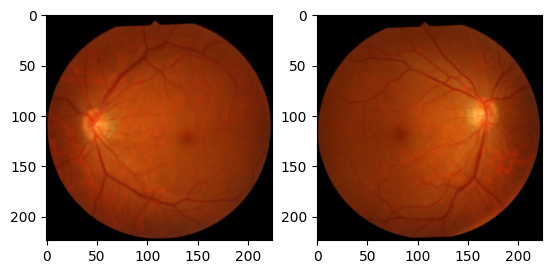

[1, 0, 0, 0, 0, 0, 0, 0]
Label: ['(N) Normal']


In [18]:
left,right,metadata,label = next(iter(train_loader))
print(f"right image batch shape: {right.size()}")

# new_mean, new_std = (0.0509, 0.2404, 1.6657), (0.3090, 0.2115, 0.1740)
# mean, std = (0.4343, 0.2787, 0.1525), (0.2878, 0.2080, 0.1454) # updated for the newly cropped images 13.01 16:05

right = right[0].squeeze()
mean_local = torch.tensor(mean).reshape(3, 1, 1)
std_local = torch.tensor(std).reshape(3, 1, 1)
right = right * std_local + mean_local
right = right.clamp(0, 1)

print(f"left image batch shape: {left.size()}")
left = left[0].squeeze()

left = left * std_local + mean_local
left = left.clamp(0, 1)

print("Image shape: ", left.size())
print(f"Labels batch shape: {label.size()}")
label = label[0]
left = torch.permute(left, (1,2,0))
right = torch.permute(right, (1,2,0))

plt.subplot(1, 2, 1)
plt.imshow(left)
plt.subplot(1, 2, 2)
plt.imshow(right)
plt.show()
print(label.int().tolist())
print(f"Label: {[cls for cls, idx in zip (classes, label) if idx == 1]}")


# Function for plotting the images and inversing the normalization

def preprocess_images_for_plot(left, right, label):
  label = [cls for cls, idx in zip (classes, label) if idx == 1]

  right = right * std_local + mean_local
  right = right.clamp(0, 1)
  right = torch.permute(right, (1,2,0))

  left = left * std_local + mean_local
  left = left.clamp(0, 1)
  left = torch.permute(left, (1,2,0))


  return left, right, label


  1%|          | 37/3500 [19:59<31:11:01, 32.42s/it]


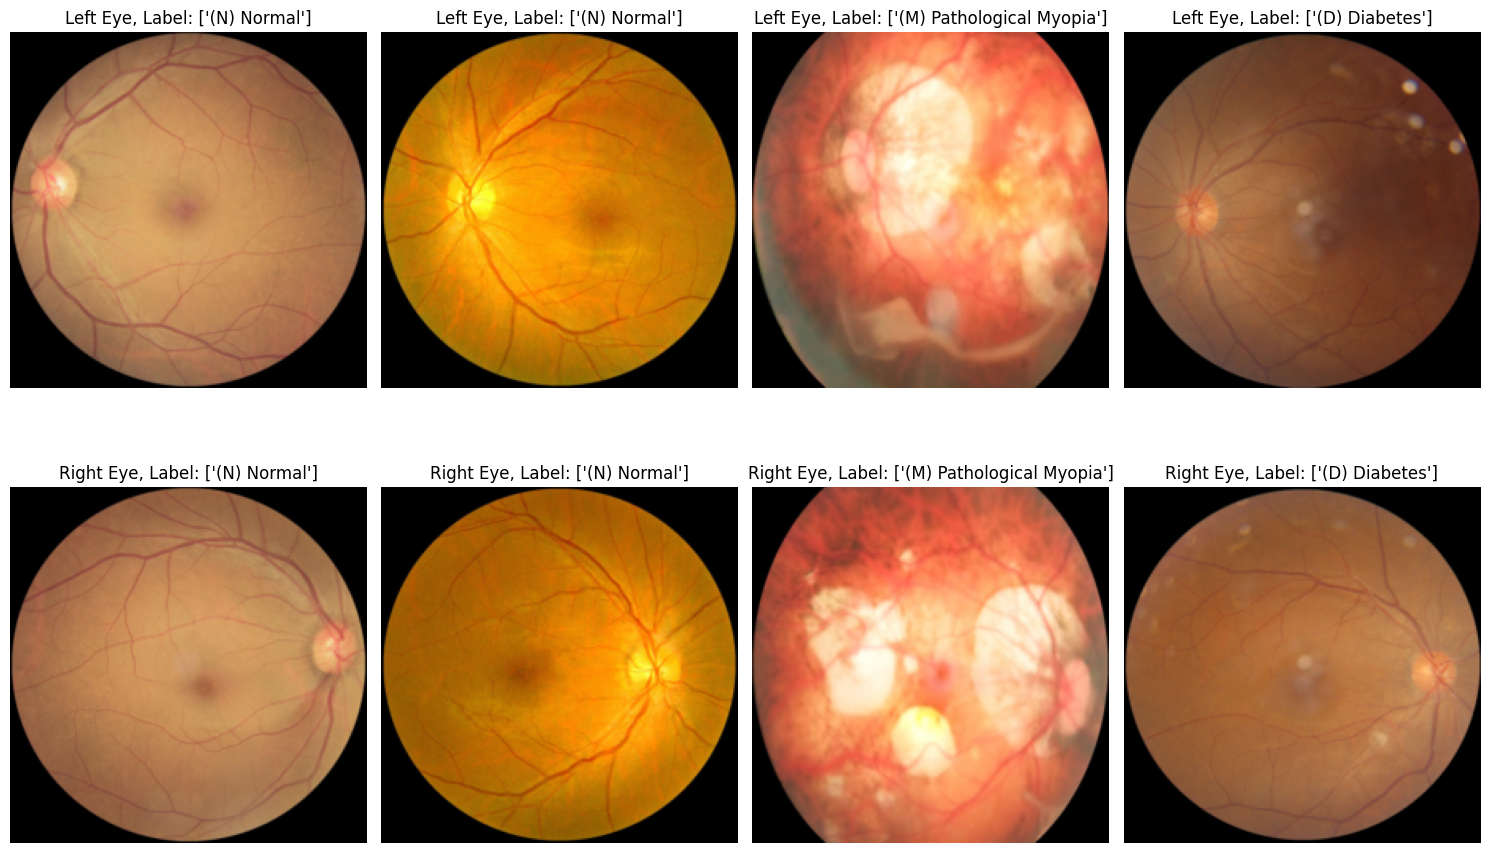

In [19]:
### VISUALIZATION ###

# Get a batch of images and labels
images_left, images_right, metainfo, labels = next(iter(train_loader))


# Set up the plot
fig, axes = plt.subplots(2, 4, figsize=(15, 10))

# Display the first four pairs of images and their labels
for idx in range(4):
    img_left, img_right, label = preprocess_images_for_plot(images_left[idx], images_right[idx], labels[idx])


    axes[0, idx].imshow(img_left)
    axes[1, idx].imshow(img_right)

    # get the class label descriptions (might be multiple)


    axes[0, idx].set_title(f"Left Eye, Label: {label}")
    axes[1, idx].set_title(f"Right Eye, Label: {label}")
    axes[0, idx].axis('off')
    axes[1, idx].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

plt.show()

[INFO] Visualizing class distribution...


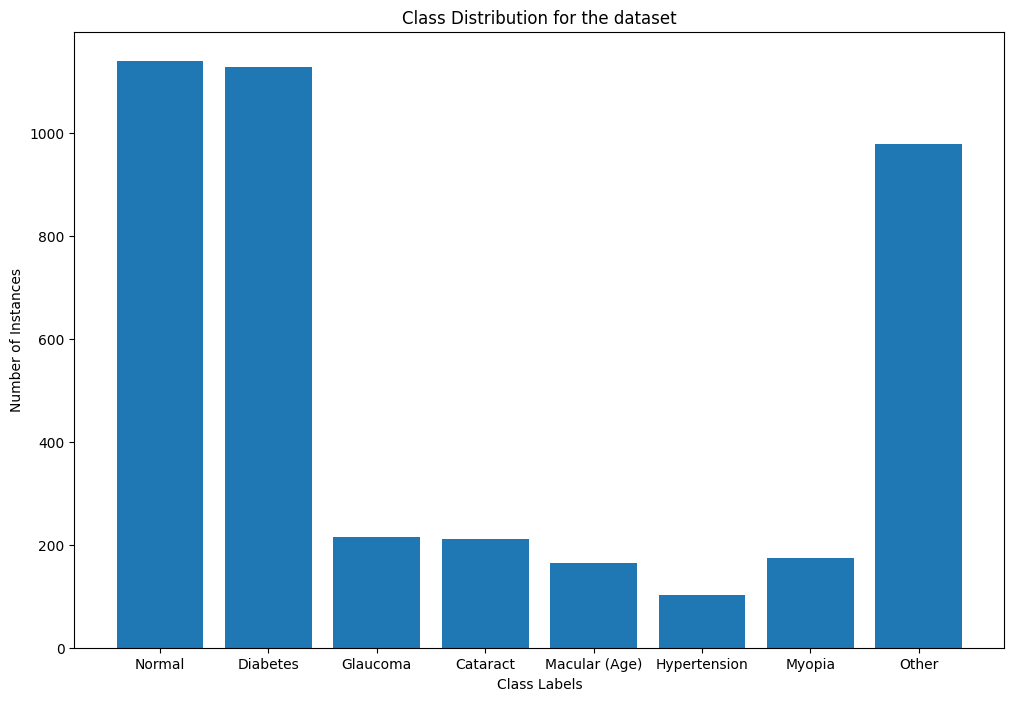

In [20]:
# Plot Class distribution
def plot_class_distribution(dataloader, title):
    """Plots class distribution for the whole dataset in a bar chart.

    Args:
        dataloader: dataset to be visualized.
        title: The title of the plot.

    Returns:
        Plot of the class distribution.
    """
   # Get the unique labels and their respective counts, use unique from numpy and explore the parameter  return_counts
    label_counts = np.zeros(8)
    for _, _, _, label in dataloader:
      labels = label.numpy()
      label_counts += labels
    # Create a bar plot
    classes_desc = ["Normal", "Diabetes", "Glaucoma", "Cataract", "Macular (Age)", "Hypertension", "Myopia", "Other"]
    plt.bar(classes_desc,label_counts)  # Create a bar plot for the class distribution
    plt.title(title)  # Set the title of the plot
    plt.xlabel('Class Labels')  # Set the x-axis label
    plt.ylabel('Number of Instances')  # Set the y-axis label
    plt.show()  # Display the plot

# Plot the class distribution
print("[INFO] Visualizing class distribution...")
plt.figure(figsize=(12, 8))

plot_class_distribution(dataset, "Class Distribution for the dataset")

When visualizing the class distribution, it can be seen that there is a class imbalance. Most of the images are classified as normal, diabetes or other. The hypertension class is the class with the fewest images. The other classes have about the same amount. This class imbalance could lead to a overfitting problem. For understanding the distribution from the subsets, it is visualized in the following step.

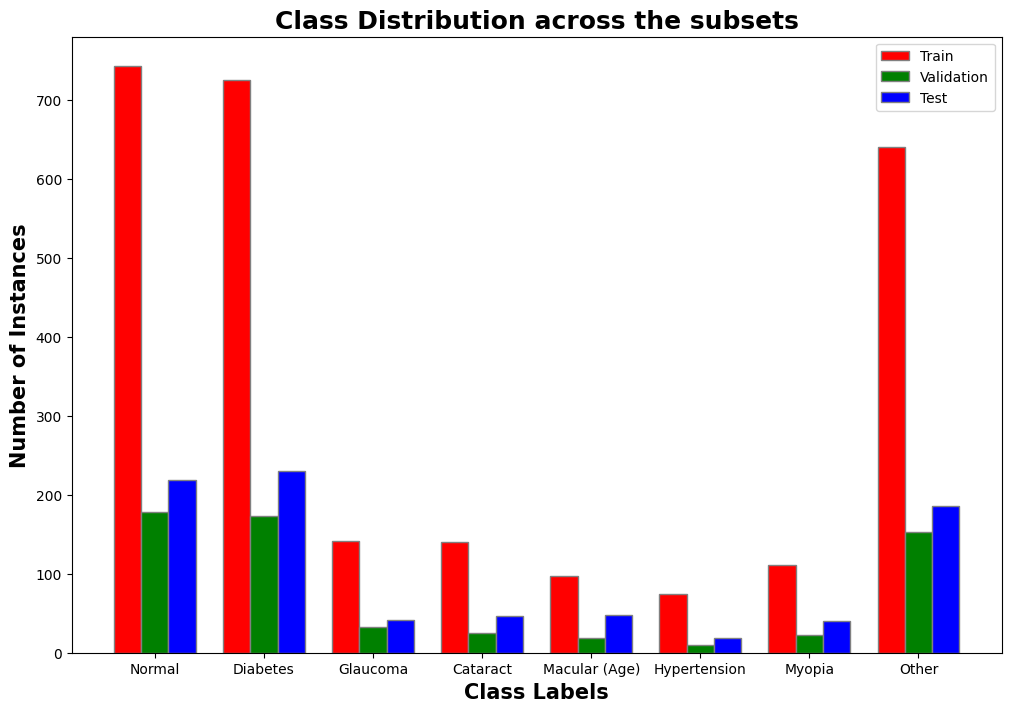

In [21]:
def plot_class_distribution_grouped(datasets, dataset_labels, title):
    """Plots class distributions for multiple datasets in a grouped bar chart.

    Args:
        datasets: A list of subsets
        dataset_labels: A list of labels corresponding to the datasets.
        title: The title of the plot.

   Returns:
        Plot of the grouped class distribution.
    """
    num_classes = 8
    class_labels = range(num_classes)
    classes_desc = ["Normal", "Diabetes", "Glaucoma", "Cataract", "Macular (Age)", "Hypertension", "Myopia", "Other"]
    bar_width = 0.25

    # Get class counts for each dataset
    dataset_counts = []
    for dataset in datasets:
        label_counts = np.zeros(num_classes)
        for _, _, _, label in dataset:
            labels = label.numpy()
            label_counts += labels
        dataset_counts.append(label_counts)

    # Create the bar plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Set position of bar on X axis
    br1 = np.arange(num_classes)
    br2 = [x + bar_width for x in br1]
    br3 = [x + bar_width for x in br2]

    # Make the plot
    ax.bar(br1, dataset_counts[0], color='r', width=bar_width, edgecolor='grey', label=dataset_labels[0])
    ax.bar(br2, dataset_counts[1], color='g', width=bar_width, edgecolor='grey', label=dataset_labels[1])
    ax.bar(br3, dataset_counts[2], color='b', width=bar_width, edgecolor='grey', label=dataset_labels[2])

    # Adding Xticks
    ax.set_xlabel('Class Labels', fontweight='bold', fontsize=15)
    ax.set_ylabel('Number of Instances', fontweight='bold', fontsize=15)
    ax.set_xticks([r + bar_width for r in range(num_classes)])
    ax.set_xticklabels(classes_desc)
    ax.set_title(title, fontweight='bold', fontsize=18)
    ax.legend()

    plt.show()

# Call the function to create the grouped bar plot
plot_class_distribution_grouped(
    [X_train, X_val, X_test],
    ['Train', 'Validation', 'Test'],
    "Class Distribution across the subsets"
)

It is important that the distribution for each class has approximately the same number of members in each of the subsets. It looks as if this has been fulfilled.

### 3.3. Find parameters for Data Normalization

The normalization parameters (mean and std) were calculated once for the training subset and then hardcoded in the beginning of the notebook to serve for normalization and de-normalization later. The parameters are:
mean, std = (0.4343, 0.2787, 0.1525), (0.2878, 0.2080, 0.1454)

In [ ]:
#Normalization - get parameter from training dataset
#stack images of left and right eye
imgs_r = torch.stack([img_r for img_r, _, _, _ in tqdm(X_train)], dim=3)
imgs_l = torch.stack([img_l for _, img_l, _, _ in tqdm(X_train)], dim=3)
print(imgs_r.shape)
print(imgs_l.shape)
#concatenate both tensors
imgs = torch.cat((imgs_r, imgs_l), dim=3)
print(imgs.shape)


print("Mean: ", imgs.view(3, -1).mean(dim=1), "Standard deviation: ", imgs.view(3, -1).std(dim=1))

## 4. Model Selection and Design

**Model Architecture:**

The primary challenge in selecting and designing the model is ensuring it can simultaneously process and analyze both images of a pair effectively.
A foundational model for retina classification, such as [RETFound_MAE](https://github.com/rmaphoh/RETFound_MAE), provide a useful starting point. However, since these models are typically designed to detect a single class, whereas this task involves handling multiple classes simultaneously, their applicability may be limited in this case.
An alternative approach involves treating each pair of images (one for each eye) as a "bag" in the context of Multiple Instance Learning (MIL). The "bag" would then be assigned a label corresponding to the diseases present in the pair of eyes. Also this method presents a challenge in handling multiple classes. It would need to be clarified whether a "bag" can support multiple labels, as this might complicate implementation.

A promising direction is inspired by the findings in the [original paper]( https://arxiv.org/pdf/2102.07978), where both images are fed into the model simultaneously. The authors explore various feature fusion methods, such as multiplication, summation, and concatenation, and conclude that summation yields the best results. Furthermore, they identify VGG-16 as the most effective network architecture for this task. Combining summation-based feature fusion with VGG-16 offer a good solution.

**Model Architecture Explanation:**
The implementation of the model was considered as follows. For the backbone model the VGG16 was used for feature extraction for each eye seperately. The use of transfer learning for this part of the model is good because it would be not enough data to extract the features by their own. After that the fusion of the features from the left and right eye is realised by summing. The classification head is inspired by the VGG16-classification. First an adaptive average pooling and a Flatten layer is implemented after the feature fusion. After that three Linear Layer are implemented for classifying the model. Additionally three Dropout layer are added to prevent overfitting. The activation function is the Relu-activation and for the last layer the sigmoid-function to get the binary classification for each class.

The following model is the VGG-16 model which we split into backbone and classification head. The backbone weight will be freezed during training later and only the head will be trained. The head ends in a output layer with 8 neurons and a Sigmoid activation function since it is a multi-class multi-label problem.

In [22]:
import torch
import torch.nn as nn
from torchvision.models import vgg16
from torchsummary import summary


class VGG16MultiLabelModel(nn.Module):
    def __init__(self, num_classes=8):
        super(VGG16MultiLabelModel, self).__init__()

        # Load pre-trained VGG16 and remove the classifier
        vgg_base = vgg16(pretrained=True)
        # print("Model print: ", vgg_base)
        # summary(vgg_base.cuda(), (3, 224, 224))


        self.shared_features = nn.Sequential(*list(vgg_base.features.children()))
        # summary(self.shared_features.cuda(), (3, 224, 224))

        # Define the classification head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((7, 7)),
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 4096),
            #nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            #nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),  # Multi-label output for 8 classes
            #nn.Dropout(0.5),
            nn.Sigmoid()  # Use sigmoid for multi-label classification
        )

    def forward(self, left_eye, right_eye):
        # Pass both left and right images through the shared feature extractor

        left_features = self.shared_features(left_eye)
        right_features = self.shared_features(right_eye)


        # Element-wise summation for feature fusion
        fused_features = torch.add(left_features, right_features)
        # print(left_features.size())
        # print(right_features.size())
        # print(fused_features.size())

        # Pass through the classifier
        output = self.classifier(fused_features)

        return output


model = VGG16MultiLabelModel(num_classes=8)
# print(model)
# summary(model.cuda(), (2, 3, 224, 224))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


A second model was created using the VGG-16 backbone and using a different head, which consist of 8 different classification heads each having a output layer of 2 neuron with a softmax for classifying each of the classes separately.

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import vgg16

class VGG16MultiLabelModel_SeparateHeads(nn.Module):
    def __init__(self, num_classes=8):
        super(VGG16MultiLabelModel_SeparateHeads, self).__init__()

        # Load pre-trained VGG16 and remove the classifier
        vgg_base = vgg16(pretrained=True)

        self.shared_features = nn.Sequential(*list(vgg_base.features.children()))

        # Define a classification head for each class
        self.classifiers = nn.ModuleList([
          nn.Sequential(
                nn.AdaptiveAvgPool2d((7, 7)),
                nn.Flatten(),
                nn.Linear(512 * 7 * 7, 1024),  # Reduced number of parameters
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(1024, 512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, 2),  # Two-class classification (binary)
                nn.Softmax(dim=1)  # Softmax for binary classification
            )
            for _ in range(num_classes)
        ])

        '''
        self.classifiers = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d((7, 7)),
                nn.Flatten(),
                nn.Linear(512 * 7 * 7, 4096),
                #nn.BatchNorm1d(4096),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(4096, 4096),
                #nn.BatchNorm1d(4096),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(4096, 2),  # Two-class classification (binary)
                nn.Softmax(dim=1)  # Softmax for binary classification
            )
            for _ in range(num_classes)
        ])
        '''

    def forward(self, left_eye, right_eye):
        # Pass both left and right images through the shared feature extractor
        left_features = self.shared_features(left_eye)
        right_features = self.shared_features(right_eye)

        # Element-wise summation for feature fusion
        fused_features = torch.add(left_features, right_features)

        # Apply each classifier to the fused features and collect the first neuron output
        outputs = []
        for classifier in self.classifiers:
            output = classifier(fused_features)
            outputs.append(output[:, 0])  # Collect the first neuron (class 0 probability)

        # Stack the outputs into a single tensor of shape (batch_size, num_classes)
        return torch.stack(outputs, dim=1)

# Example usage
if __name__ == "__main__":
    model = VGG16MultiLabelModel_SeparateHeads(num_classes=8).cuda()
    left_eye_input = torch.randn(1, 3, 224, 224).cuda()  # Example input for left eye
    right_eye_input = torch.randn(1, 3, 224, 224).cuda()  # Example input for right eye

    outputs = model(left_eye_input, right_eye_input)
    print(f"Output tensor: {outputs}")


In [ ]:
torch.cuda.empty_cache()

# 5. Training and Validation
For training the model it was first necessary to specify the optimizier and the Loss function. Although there are 8 classes, the objective is to classify every class seperatedly as 0 or 1. Therefore the Binary-Cross-Entropy loss was implemented to achieve this binary classification. The learning rate within the optimizer is specified low with a number of 0.0001 to achieve a slow learning. The batch size was 16 and the number of epochs started with 10. When changing to a higher number more overfitting was shown in the last epochs. The decision for a threshold of the number of 0.5 was defined for choosing the classes. If the probability to the class is less than 0.5 it will get a 0, otherwise a 1.

**Hyperparameter Tuning:**

Hyperparameter tuning could only be done manually due to RAM limitations. Therefore, some manual changes are made within the hyperparameter choice. Changing the optimiser from Adam to SGD did not change the overfitting problems much. Also, changing to more epochs (30) and faster learning with lr= 0.01 and a stricter weight decay of 1e-7 didn't help. It changed the training and evaluation graph in a way to get faster a lower loss. However, the overall F1 score did not match the F1 score of the best model we trained.

**Overfitting prevention:**

To prevent overfitting dropout layers with a rate of 0.5 is implemented after the two first linear layer. Because this couldn't help against the overfitting issue, different regularization techniques are used. We tried two different methods, which are the L1 and the weight decay, which is based on the L2 norm. Implementing the L2 was the better option which could prevent overfitting for more epochs.

----------------------------------
Epoch 1/10


100%|██████████| 143/143 [00:33<00:00,  4.22it/s]


Epoch 1/10, Loss: 0.3588, F1-Score: 0.2087


100%|██████████| 33/33 [00:05<00:00,  5.97it/s]


Validation Loss: 0.3164, Validation F1-Score: 0.2140
----------------------------------
Epoch 2/10


100%|██████████| 143/143 [00:30<00:00,  4.75it/s]


Epoch 2/10, Loss: 0.3124, F1-Score: 0.2804


100%|██████████| 33/33 [00:05<00:00,  6.17it/s]


Validation Loss: 0.3223, Validation F1-Score: 0.2454
----------------------------------
Epoch 3/10


100%|██████████| 143/143 [00:29<00:00,  4.80it/s]


Epoch 3/10, Loss: 0.2940, F1-Score: 0.3314


100%|██████████| 33/33 [00:05<00:00,  6.07it/s]


Validation Loss: 0.2921, Validation F1-Score: 0.2663
----------------------------------
Epoch 4/10


100%|██████████| 143/143 [00:30<00:00,  4.73it/s]


Epoch 4/10, Loss: 0.2777, F1-Score: 0.3982


100%|██████████| 33/33 [00:05<00:00,  6.14it/s]


Validation Loss: 0.3057, Validation F1-Score: 0.2954
----------------------------------
Epoch 5/10


100%|██████████| 143/143 [00:29<00:00,  4.79it/s]


Epoch 5/10, Loss: 0.2619, F1-Score: 0.4273


100%|██████████| 33/33 [00:05<00:00,  6.04it/s]


Validation Loss: 0.3044, Validation F1-Score: 0.3070
----------------------------------
Epoch 6/10


100%|██████████| 143/143 [00:29<00:00,  4.78it/s]


Epoch 6/10, Loss: 0.2461, F1-Score: 0.4888


100%|██████████| 33/33 [00:05<00:00,  6.15it/s]


Validation Loss: 0.3151, Validation F1-Score: 0.3305
----------------------------------
Epoch 7/10


100%|██████████| 143/143 [00:29<00:00,  4.78it/s]


Epoch 7/10, Loss: 0.2271, F1-Score: 0.5360


100%|██████████| 33/33 [00:05<00:00,  6.02it/s]


Validation Loss: 0.3033, Validation F1-Score: 0.3456
----------------------------------
Epoch 8/10


100%|██████████| 143/143 [00:29<00:00,  4.78it/s]


Epoch 8/10, Loss: 0.2020, F1-Score: 0.6047


100%|██████████| 33/33 [00:05<00:00,  6.17it/s]


Validation Loss: 0.3074, Validation F1-Score: 0.3909
----------------------------------
Epoch 9/10


100%|██████████| 143/143 [00:30<00:00,  4.76it/s]


Epoch 9/10, Loss: 0.1841, F1-Score: 0.6678


100%|██████████| 33/33 [00:05<00:00,  6.03it/s]


Validation Loss: 0.3068, Validation F1-Score: 0.3945
----------------------------------
Epoch 10/10


100%|██████████| 143/143 [00:29<00:00,  4.78it/s]


Epoch 10/10, Loss: 0.1647, F1-Score: 0.7132


100%|██████████| 33/33 [00:06<00:00,  5.32it/s]


Validation Loss: 0.3215, Validation F1-Score: 0.3742


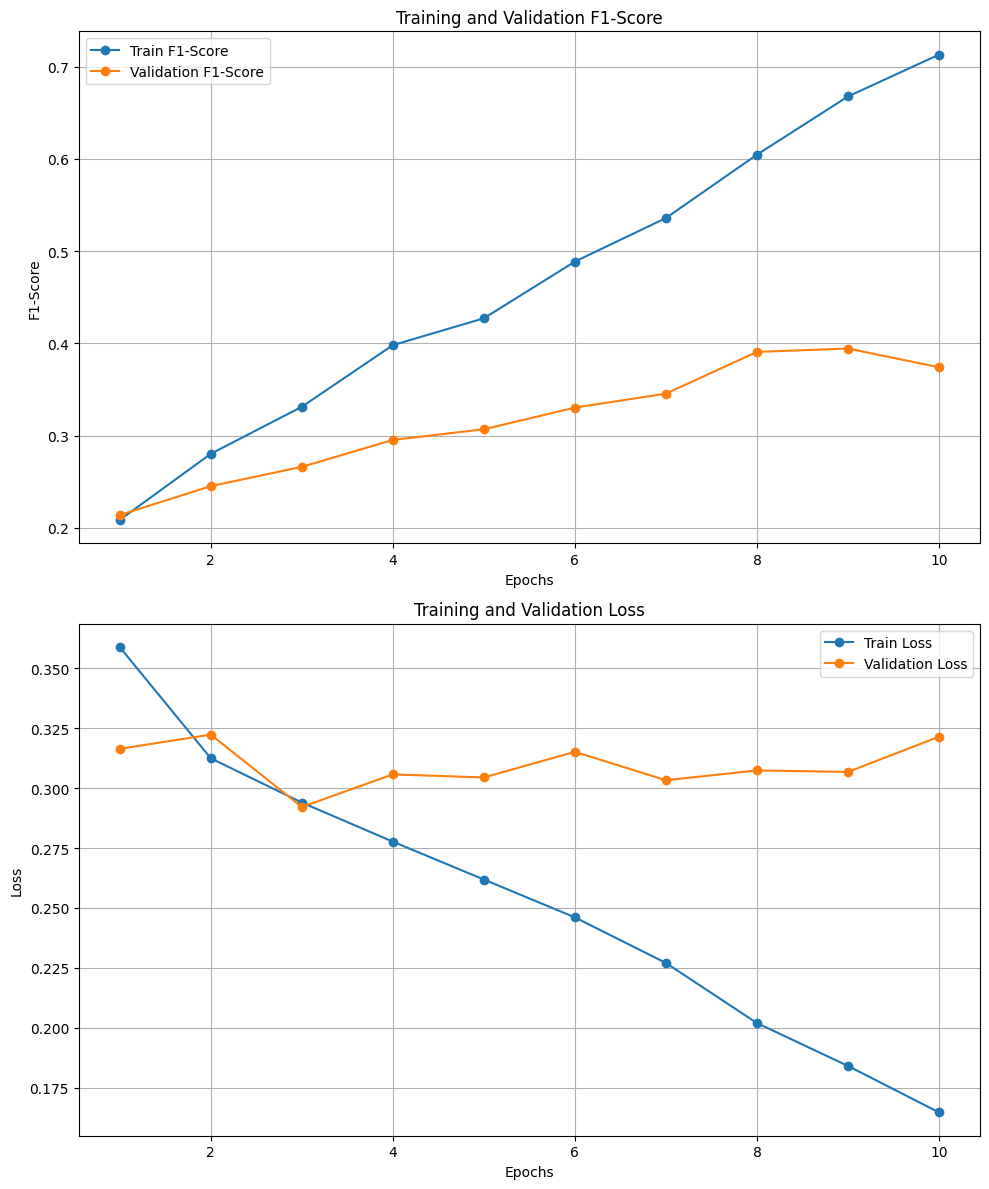

In [23]:
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = VGG16MultiLabelModel_SeparateHeads(num_classes=8).to(device)
model = VGG16MultiLabelModel(num_classes=8).to(device)

for param in model.shared_features.parameters():
    param.requires_grad = False

params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

# Define optimizer and loss function
optimizer = optim.Adam(params_to_update, lr=1e-4, weight_decay = 1e-4)
#optimizer = optim.SGD(params_to_update, lr=0.001, weight_decay=1e-6, momentum=0.9, nesterov=True)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification

lambda_reg = 0.00008
regularization_type = 'none'


# Training loop
epochs = 10
train_f1_scores = []
val_f1_scores = []
train_losses = []
val_losses = []

for epoch in range(epochs):
    print("----------------------------------")
    print(f"Epoch {epoch+1}/{epochs}")
    model.train()
    total_loss = 0
    all_labels = []
    all_preds = []

    for left_eye, right_eye, _, labels in tqdm(train_loader):
        # Move data to device
        left_eye, right_eye, labels = left_eye.to(device), right_eye.to(device), labels.to(device)

        # Forward pass
        outputs = model(left_eye, right_eye)

        # Compute loss
        loss = criterion(outputs, labels)
        # Apply L1 regularization
        if regularization_type == 'L1':
            l1_norm = sum(p.abs().sum() for p in params_to_update)/len(params_to_update)
            loss += lambda_reg * l1_norm

        # Apply L2 regularization
        elif regularization_type == 'L2':
            l2_norm = sum(p.pow(2).sum() for p in params_to_update)/len(params_to_update)
            loss += lambda_reg * l2_norm

        else:
          pass

        total_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Collect predictions and labels for F1-score computation
        all_labels.append(labels.cpu().numpy())
        #print((outputs > 0.5))
        all_preds.append((outputs > 0.5).cpu().numpy())

    train_losses.append(total_loss / len(train_loader))
    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)
    train_f1 = f1_score(all_labels, all_preds, average='macro')
    train_f1_scores.append(train_f1)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, F1-Score: {train_f1:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    val_labels = []
    val_preds = []

    with torch.no_grad():
        for left_eye, right_eye, _, labels in tqdm(val_loader):
            left_eye, right_eye, labels = left_eye.to(device), right_eye.to(device), labels.to(device)
            outputs = model(left_eye, right_eye)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Collect predictions and labels for F1-score computation
            val_labels.append(labels.cpu().numpy())
            val_preds.append((outputs > 0.5).cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_labels = np.concatenate(val_labels, axis=0)
    val_preds = np.concatenate(val_preds, axis=0)
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    val_f1_scores.append(val_f1)

    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation F1-Score: {val_f1:.4f}")

# Plot F1-scores and losses
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plot F1-scores
axs[0].plot(range(1, epochs + 1), train_f1_scores, label='Train F1-Score', marker='o')
axs[0].plot(range(1, epochs + 1), val_f1_scores, label='Validation F1-Score', marker='o')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('F1-Score')
axs[0].set_title('Training and Validation F1-Score')
axs[0].legend()
axs[0].grid(True)

# Plot losses
axs[1].plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
axs[1].plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='o')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


## *Note*

 Note that this is just one example training process. We will include more of our trainings of other models in the presentation.

In [24]:
torch.save(model, "VGG16SingleHead_4096_Neurons.pth")

# 6. Model Evaluation and Metrics

Below, you can find how the model performed based on evaluation metrics used in the paper [1] [Linktext](https://): F1-score, AUC, Kappa score, and a final score being the average of the previous three. We have also computed the confusion matrices for each of the disease classes. Kappa coefficient is used for consistency check, and it ranges from -1 to 1. F1 is the harmonic mean of precision and recall, which is high only when precision and recall are both high.

Model 1 (VGG16 with 4096 Neurons)
First we trained a model using a head similar to the Head used in the VGG16 model.
It achieved a final score of 0.5582.
To prevent overfitting we used a weight Decay of 1e-4 in the Optimizer.

Model 2 (VGG16 with 2048 Neurons)
For a second model we used the head of the VGG16 model but reduced the size of the fully connected layers to 2048 Neurons.
With a use of similar hyperparameters some overfitting is visible after 6-10 epochs.
The final score with 0.5535 is a little bit lower than the model before.

Model 3 (VGG16 with separate heads for each class)
For the third model the head of the VGG16 was changed to be 8 different heads of smaller Dimension and two Output Neurons with softmax activation. This model achieves the lowest final score of 0.5344 and during Training overfitting is clearly visible.

In conclusion changing the model structure didn't influence the final score a lot. The hyperparameters helped with reducing overfitting but the Overall final score stays in the range of 0.55


In [25]:
# prompt: Evaluate the performance of the model through a confusion matrix, Kappa, F1-
# score (F1), AUC and the mean value of the last three, that you will name 'Final'

from sklearn.metrics import confusion_matrix, cohen_kappa_score, f1_score, roc_auc_score
import numpy as np

# Assuming you have your model's predictions and true labels
# Replace these with your actual predictions and labels from the test set
y_true = [] #true labels
y_pred = [] #predicted labels (probabilities)

# Iterate over the test dataloader to get the true labels and predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculations during inference
    for left_eye, right_eye, _, labels in test_loader:
        left_eye, right_eye, labels = left_eye.to(device), right_eye.to(device), labels.to(device)
        outputs = model(left_eye, right_eye)  # Get model predictions

        # Append the true labels and predicted probabilities
        y_true.extend(labels.cpu().numpy())  # Move labels to CPU and convert to NumPy
        y_pred.extend(outputs.cpu().numpy())  # Move predictions to CPU and convert to NumPy



In [26]:
# Convert probabilities to binary predictions (e.g., threshold = 0.5)
y_pred_binary = (np.array(y_pred) > 0.5).astype(int)

label_counts = [1140, 1128,  215,  212,  164,  103,  174,  979,]

# Initialize a list to store metrics for each class
kappas = []
f1s = []
AUCs = []
final_scores = []
confusion_matrices = []

# Iterate through each class and calculate its metrics
for i in range(y_pred_binary.shape[1]):  # Assuming 8 classes
    # Get true and predicted labels for the current class
    true_labels_class_i = [row[i] for row in y_true]
    predicted_labels_class_i = y_pred_binary[:, i]

    # Calculate the metrics for the current class
    kappa_i = cohen_kappa_score(true_labels_class_i, predicted_labels_class_i)
    f1_i = f1_score(true_labels_class_i, predicted_labels_class_i, average='macro')
    auc_i = roc_auc_score(true_labels_class_i, predicted_labels_class_i, average='macro', multi_class='ovo')
    final_score_i = (kappa_i + f1_i + auc_i) / 3
    cm_class_i = confusion_matrix(true_labels_class_i, predicted_labels_class_i)

    # Store the metrics for the current class
    kappas.append(kappa_i)
    f1s.append(f1_i)
    AUCs.append(auc_i)
    final_scores.append(final_score_i)
    confusion_matrices.append(cm_class_i)

    # Print the results for each class
    #print(f"Class {i}")
    #print(f"Confusion Matrix:\n", cm_class_i)
    #print(f"Kappa: {kappa_i}")
    #print(f"F1-score: {f1_i}")
    #print(f"AUC: {auc_i}")
    #print(f"Final Score: {final_score_i}")

# For example, if you need a single aggregated confusion matrix, you can sum the individual matrices:
# aggregated_cm = np.sum(confusion_matrices, axis=0)
# print("Aggregated Confusion Matrix:\n", aggregated_cm)

# Create a list to store string representations of confusion matrices
cm_strings = [np.array2string(cm) for cm in confusion_matrices]

# Create a DataFrame to store the results, including confusion matrix strings
results_df = pd.DataFrame({
    'Class': range(y_pred_binary.shape[1]),
    'Class_name' : classes,
    'Kappa': kappas,
    'F1-score': f1s,
    'AUC': AUCs,
    'Final Score': final_scores,
    'Class_count' : label_counts,
    'Confusion Matrix': cm_strings  # Add the confusion matrix strings
})

# Set the 'Class' column as the index and then reset the index
results_df = results_df.set_index('Class').reset_index()

# Calculate the average of each metric across all classes
average_kappa = results_df['Kappa'].mean()
average_f1 = results_df['F1-score'].mean()
average_auc = results_df['AUC'].mean()
average_final_score = results_df['Final Score'].mean()

# Print the average scores
print(f"Average Kappa: {average_kappa:.4f}")
print(f"Average F1-score: {average_f1:.4f}")
print(f"Average AUC: {average_auc:.4f}")
print(f"Average Final Score: {average_final_score:.4f}")

# Print the DataFrame
print(results_df)

Average Kappa: 0.3504
Average F1-score: 0.6696
Average AUC: 0.6545
Average Final Score: 0.5582
   Class                            Class_name     Kappa  F1-score       AUC  \
0      0                            (N) Normal  0.299670  0.648626  0.657102   
1      1                          (D) Diabetes  0.267380  0.633307  0.630574   
2      2                          (G) Glaucoma  0.391172  0.691817  0.630193   
3      3                          (C) Cataract  0.742737  0.871313  0.845704   
4      4  (A) Age related Macular Degeneration  0.038124  0.503014  0.510417   
5      5                      (H) Hypertension  0.084129  0.538198  0.524847   
6      6               (M) Pathological Myopia  0.853679  0.926790  0.886742   
7      7                             (O) Other  0.126229  0.543844  0.550772   

   Final Score  Class_count         Confusion Matrix  
0     0.535133         1140  [[351 130]\n [ 91 128]]  
1     0.510420         1128  [[370 100]\n [121 109]]  
2     0.571060     

<ipython-input-27-574e716c3141>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  y_true_tensor = torch.tensor(y_true).int()


tensor([[0, 0, 1,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        ...,
        [0, 1, 0,  ..., 0, 0, 1],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 1]], dtype=torch.int32)
tensor([[0, 0, 1,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 1],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0]], dtype=torch.int32)


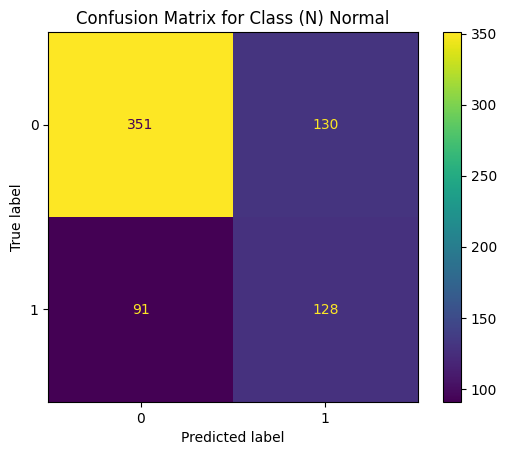

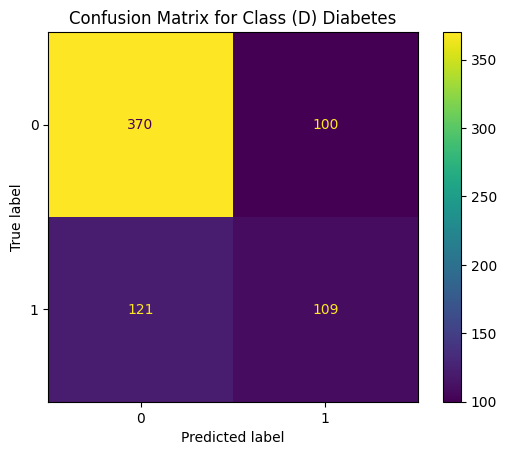

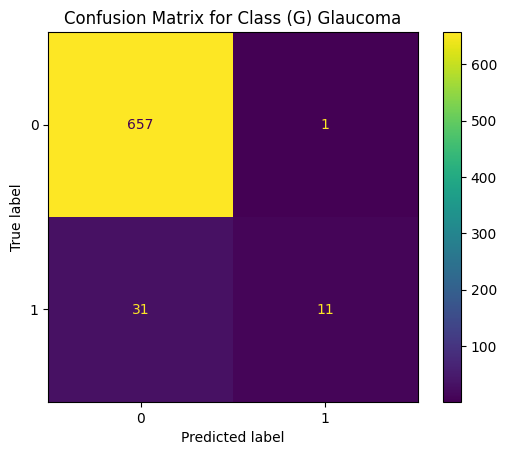

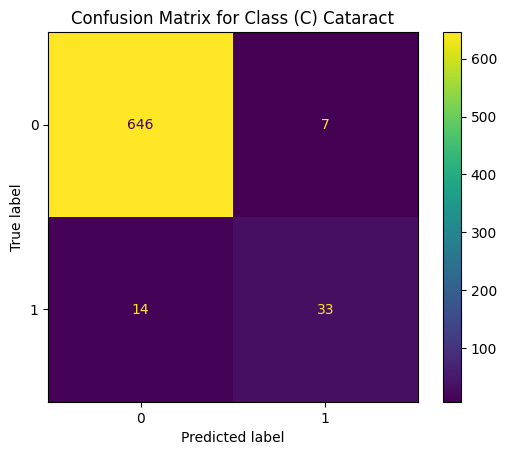

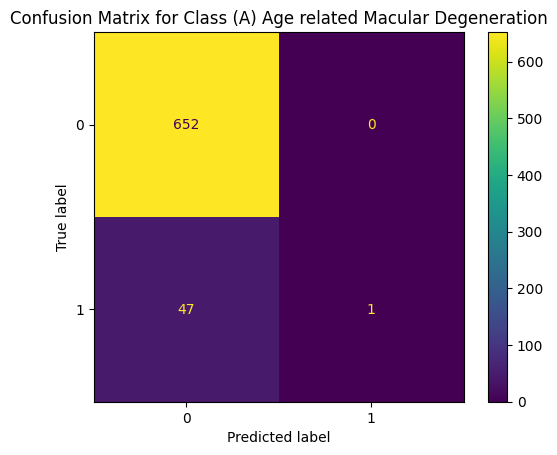

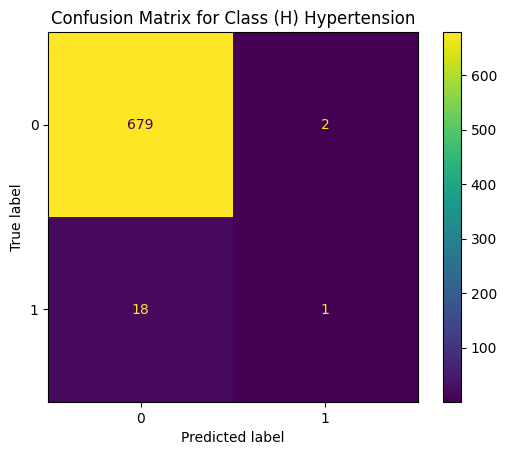

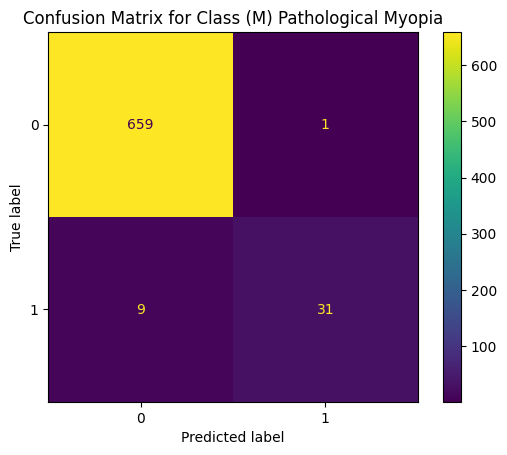

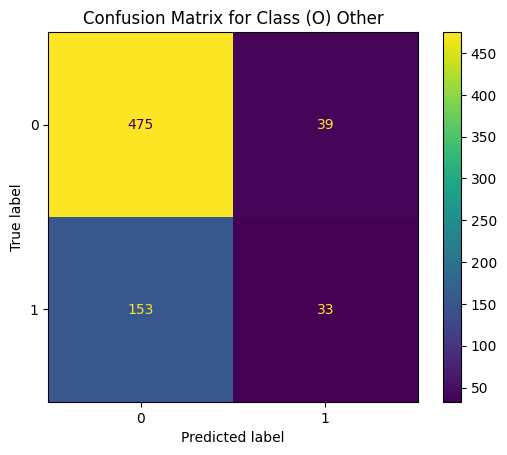

In [27]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

y_true_tensor = torch.tensor(y_true).int()
y_pred_tensor = torch.tensor(y_pred_binary).int()

print(y_true_tensor)
print(y_pred_tensor)
# CONFUSION MATRIX
cm = multilabel_confusion_matrix(y_true_tensor, y_pred_tensor)
#classes = ["(N)", "(D)", "(G)", "(C)", "(A)", "(H)", "(M)", "(O)"]
# Display the confusion matrix
for i in range(len(cm)):
  disp = ConfusionMatrixDisplay(confusion_matrix=cm[i])
  disp.plot()
  disp.ax_.set_title(f'Confusion Matrix for Class {classes[i]}')
  plt.show()

In [42]:
def show_examples(model, test_loader, device, classes):
    """Displays examples of correctly and incorrectly classified images.

    Args:
        model: The trained model.
        test_loader: DataLoader for the test dataset.
        device: The device to run the model on (CPU or GPU).
        classes: A list of class names.
    """

    # Switch model to evaluation mode
    model.eval()

    # Get a batch of data
    left_eye, right_eye, _, labels = next(iter(test_loader))
    left_eye, right_eye, labels = left_eye.to(device), right_eye.to(device), labels.to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(left_eye, right_eye)
        predicted_labels = (outputs > 0.5)

    # Find correctly and incorrectly classified examples
    correct_indices = torch.where(torch.all(predicted_labels == labels, dim=1))[0]
    incorrect_indices = torch.where(torch.any(predicted_labels != labels, dim=1))[0]

    # Display examples
    print("Correctly Classified Examples:")
    for i in correct_indices[:2]:  # Show 2 correct examples
        img_left, img_right, label = preprocess_images_for_plot(left_eye[i].cpu(), right_eye[i].cpu(), labels[i].cpu())
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img_left)
        plt.title(f"True Label: {[cls for cls, idx in zip(classes, label)]}")
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(img_right)
        #plt.title(f"Right Eye, True Label: {[cls for cls, idx in zip(classes, label) if idx == 1]}")
        plt.axis('off')
        plt.show()

    print("\nIncorrectly Classified Examples:")
    for i in incorrect_indices[:2]:  # Show 2 incorrect examples
        img_left, img_right, label = preprocess_images_for_plot(left_eye[i].cpu(), right_eye[i].cpu(), labels[i].cpu())
        true_labels = [cls for cls, idx in zip(classes, labels[i]) if idx == 1]
        predicted_classes = [cls for cls, idx in zip(classes, predicted_labels[i]) if idx == 1]

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img_left)
        plt.title(f"True Label: {true_labels}, Predicted: {predicted_classes}")
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(img_right)
        #plt.title(f"Right Eye, True Label: {true_labels}, Predicted: {predicted_classes}")
        plt.axis('off')
        plt.show()

Correctly Classified Examples:


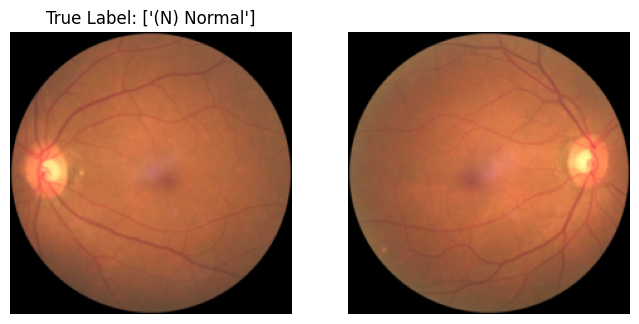

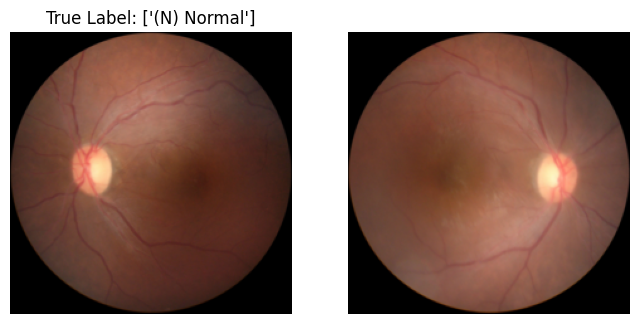


Incorrectly Classified Examples:


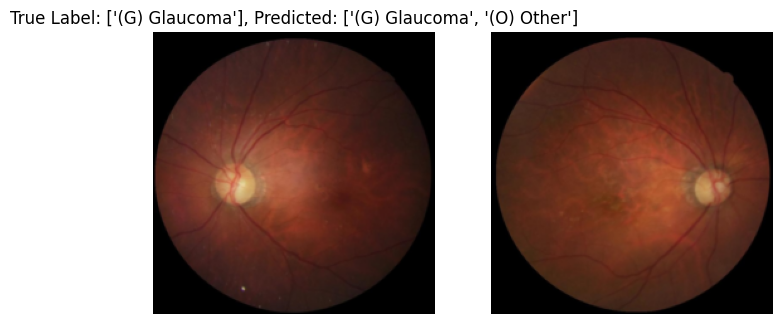

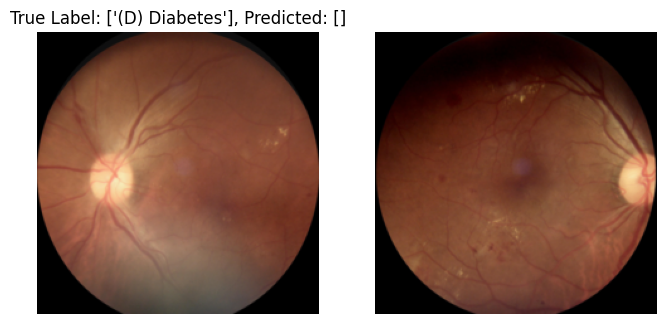

In [43]:
# Call the function to display examples
show_examples(model, test_loader, device, classes)

# 7. Discussion and Conclusion

While working on this project to train a model to recognize eye diseases, we have attained fairly good results. As can be seen above, the validation loss and F1-score are acceptable, and the model isn't excessively overfitting. While the results are acceptable, we would have still liked the model to reach 80%, or even 90% of accuracy on the validation. However, we are still satisfied for a first project on Artificial Vision. We are especially proud of the preprocessing of the dataset, notably with our implementation of lazy loading and cropping.

We have faced a few challenges in the course of the project. We had to brainstorm for a model to use, and we finally settled for VGG16. We had to deal with having pairs of images on which to train the model instead of individual images. We had to face some trial and error with the hyperparameters to achieve interesting results. We had to prepare and preprocess the data in a convenient way for the model. And, last but not least, we had to face the limitations of the Google Colab environment, which is not exactly Taylor-made for teamwork, nor the fastest for its users on the free plan.

As can be seen by the confusion matricies, the model still mis-classifies a lot of the diseases. As many of the classes only have a small amount of samples (like 103 for Hypertension or 164 for Age related Macular Degeneration) the Training is imbalanced.

The dataset contains 3500 samples which were split into Train/Validation/Test Data in subsets of 2275/525/700. For the Level of complexity of this task, the dataset is quite small especially considering the class imbalance, meaning that some classes only have under 100 samples. This explains also the overfitting which is encountered with a lot of the Trainings.

Still for some classes like Pathological Myopia or Caracarat the model achieves a quite high finals score of about 0.9
To achieve a overall better classification performance data augmentation could help to increase generalization abilities. The best solution to avoid overfitting and improve classification Performance however would be a bigger Dataset with more samples for the different classes.

As for the limitations of the model itself, we believe that there are two main issues that should be addressed to improve the model. The first is about the data processing. To manage the issue of having two eyes, we combined each pair into a single image, that was then given to the model. Perhaps this way of fusing the data was not optimal, and added noise to the model, since for a given candidate the two eyes could have different diseases. The second issue is the lack of data augmentation. We have tried to implement it, but have faced technical issues and it did not make it into the final version of the notebook. Data augmentation could have provided more ground for training, as well as have compensated for the imbalance of data in some of the categories.

### Sources:
[1] 2021, A Benchmark of Ocular Disease Intelligent Recognition: One Shot for Multi-disease Detection, Ning Li et. al ng Kang, https://arxiv.org/abs/2102.07978v1